In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import metrics

In [10]:
data = pd.read_csv('TestData/SimulatedDataCoherence/HighCoherence.csv',header=None)
data = ((data) * 2.0)-1

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


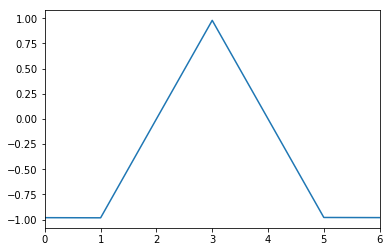

In [11]:
sns.tsplot(np.array(data))

In [12]:
class Rapooc_test(object):
    def __init__(self, D, k, l, K):
        self._D = np.array(D)
        assert k>0 and l >0, "invalid values, k>0 and l>0"
        self._k = k
        self._l = l
        assert K <= k*l and k>=1, "invalid values, 1<= K <= k*l"
        self._K = K
        self._rho = np.ones(D.shape[0])
        self._gamma = np.ones(D.shape[1])
        self._M, self._N = self._D.shape
        self._rows_h_score = None
        self._cols_h_score = None
        self._cluster_H_values = np.array([ [0.0] * (int(self._k) + 1)  
                                    for _ in range(int(self._l + 1))])
    
            
    @property
    def rho(self):
        return self._rho
    
    @property
    def gamma(self):
        return self._gamma
    
    @property
    def bicluster_h_values(self):
        assert not self._cluster_H_values is None, "H values have not yet been calculated"
        return self._cluster_H_values

    def initialize(self):
        i = 1
        j = 1
        while (i < self._k or j < self._l):
            if i < self._k:
                i += 1
                alpha = self._argmin_H_(self._rho, self._gamma,'row')
                self._bisect_partitions_(self._D[np.where(self._rho ==alpha)], self._rho, alpha, i,'row')
            if j < self._l:
                j += 1
                beta = self._argmin_H_(self._rho,self._gamma, 'column')
                self._bisect_partitions_(self._D.T, self._gamma, beta, j,'column')   

    def _argmin_H_(self, row_co_cluster, col_co_cluster,option='row'):
        if (option=='row'):
            data = self._D
        else:
            data = self._D.T
        h_min = math.inf
        min_cocluster = 1
        map_array = np.int64(row_co_cluster if option == 'row' else col_co_cluster)
        max_index_in_map = np.max(map_array)
        for i in range(1,max_index_in_map + 1):
            if (list(map_array).count(i) < 2):
                pass
            else:
                coherence = PairBasedCoherence(
                    data[np.where((row_co_cluster if option == 'row' else col_co_cluster) == i)]).HP 
                if (coherence <= h_min):
                    h_min = coherence
                    min_cocluster = i
        return min_cocluster
    
    def _bisect_partitions_ (self, data, mapping_array, cluster_to_replace, new_cluster_index,option='row'):
        clusterer = BisectingClusterer(data)
        bisected_map = clusterer.fit()
        bisected_map_index = 0
        if option == 'row':
            for i in range(0,len(mapping_array)):
                if ((self._rho if option == 'row' else self._gamma)[i] == cluster_to_replace):
                    if (bisected_map[bisected_map_index] == 1.0):
                        (self._rho if option == 'row' else self._gamma)[i] = new_cluster_index
                    bisected_map_index += 1
        else:
            clusterer = BisectingClusterer(data[np.where(self._rho == cluster_to_replace)])
            centroids = clusterer.compute_centroids()

In [16]:
class BisectingClusterer(object):
    def __init__(self, data):
        self._option = option
        if data is not None:
            self._data = np.array(data)
            self._I, self._J = self._data.shape
        else:
            print("Empty data")
    
    @property
    def centroids(self):
        if self._centroids is not None:
            return self._centroids
        else:
            print ("centroids not computed yet")
            return [0,0]
    
    def less_coherent_item(self):
        max_correlation = 0
        if self._I == 2:
            return -1
        for i in range(self._I):
            for j in range(i+1, self._I):
                if (i == j):
                    break
                correlation = PositiveNegativeCorrelation(self._data[i],
                                                          self._data[j],
                                                          self._J).H_neg
                if(correlation > max_correlation):
                    max_correlation = correlation
                    centroids[0] = i
                    centroids[1] = j
        return centroids

    def fit(self):
        self._centroids = self._compute_centroids_()
        bisecting_indices = self._bisect_clusters_(self._centroids)
        return bisecting_indices
    
    def _compute_centroids_(self):
        max_correlation = 0
        centroids = [0,0]
        for i in range(self._I):
            for j in range(i+1, self._I):
                if (i == j):
                    break
                correlation = PositiveNegativeCorrelation(self._data[i],
                                                          self._data[j],
                                                          self._J).H_neg
                if(correlation > max_correlation):
                    max_correlation = correlation
                    centroids[0] = i
                    centroids[1] = j
        return centroids

    def _bisect_clusters_(self, centroids):
        cluster_indices = np.zeros(self._I)
        for i in range(self._I):
            correlation0 = PositiveNegativeCorrelation(
                self._data[centroids[0]], self._data[i],self._J).H_pos
            correlation1 = PositiveNegativeCorrelation(
                self._data[centroids[1]], self._data[i],self._J).H_pos
            if(correlation0 <= correlation1):
                cluster_indices[i] = 1
        return cluster_indices